# Imports

In [188]:
#imports
import torch
import torch.nn as nn
from torch import mean
import torch.nn.functional as func
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.data.sampler import SubsetRandomSampler

In [189]:
# configs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 100

# Data Loading

In [190]:
# Load Training Data
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
num_train = len(train_dataset)
indices = list(range(num_train))
#train with 1000 images, divided in batch of 8(100 images in each batch)
train_idx = indices[:10000]
train_sampler = SubsetRandomSampler(train_idx)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=train_sampler)

In [191]:
# Load the test data
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)
num_test = len(test_dataset)
indices = list(range(num_test))
#test with 200 images
test_idx = indices[:200]
test_sampler = SubsetRandomSampler(test_idx)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

# Network implementation

In [192]:
class Generator(nn.Module):
    def __init__(self, generator_input_dim, generator_output_dim):
        super(Generator, self).__init__()       
        self.linear1 = nn.Linear(generator_input_dim, 256)
        self.linear2 = nn.Linear(256, 512)
        self.linear3 = nn.Linear(512, generator_output_dim)
    
    def forward(self, inp): 
        inp = nn.ReLU()(self.linear1(inp))
        inp = nn.ReLU()(self.linear2(inp))
        inp = nn.Tanh()(self.linear3(inp))
        return inp
    
class Discriminator(nn.Module):
    def __init__(self, discriminator_input_dim):
        super(Discriminator, self).__init__()
        self.linear1 = nn.Linear(discriminator_input_dim, 256)
        self.linear2 = nn.Linear(256, 256)
        self.linear3 = nn.Linear(256, 1)
    
    def forward(self, inp):
        inp = nn.LeakyReLU(0.2)(self.linear1(inp))
        inp = nn.LeakyReLU(0.2)(self.linear2(inp))
        inp = nn.Sigmoid()(self.linear3(inp))
        return inp

In [193]:
# build network
noise_dim = 64
flattened_input_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

generator = Generator(generator_input_dim = noise_dim, generator_output_dim = flattened_input_dim).to(device)
discriminator = Discriminator(flattened_input_dim).to(device)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


# Training

In [194]:

# loss function
loss = nn.BCELoss() 

# optimizer
G_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.85, 0.99))
D_optimizer = optim.Adam(discriminator.parameters(), lr=0.00005, betas=(0.85, 0.99))

In [195]:
def train_discriminator(img):
    discriminator.train()
    for i in range(0,1):
      discriminator.zero_grad()

      # train discriminator on real image
      real_image, real_label = img.view(-1, flattened_input_dim), torch.ones(batch_size, 1)
      real_image, real_label = Variable(real_image.to(device)), Variable(real_label.to(device))

      discriminator_output1 = discriminator(real_image)
      discriminator_real_loss = func.binary_cross_entropy(discriminator_output1, real_label)
      discriminator_real_loss.backward()

      # train discriminator on fake image
      latent_noise = Variable(torch.randn(batch_size, noise_dim).to(device))
      fake_image, fake_label = generator(latent_noise).detach(), Variable(torch.zeros(batch_size, 1).to(device))
      discriminator_output2 = discriminator(fake_image)
      discriminator_fake_loss = func.binary_cross_entropy(discriminator_output2, fake_label)
      discriminator_fake_score = discriminator_output2
      discriminator_loss = discriminator_real_loss + discriminator_fake_loss
      discriminator_fake_loss.backward()
      D_optimizer.step()
        
    return  discriminator_loss.data.item()

In [196]:
def train_generator():
    generator.train()

    noise = Variable(torch.randn(batch_size, noise_dim).to(device))
    y = Variable(torch.ones(batch_size, 1).to(device))

    generator_output = generator(noise)
    discriminator_output = discriminator(generator_output)
    generator_loss = func.binary_cross_entropy(discriminator_output, y)
    generator.zero_grad()
    generator_loss.backward()
    G_optimizer.step()
        
    return (generator_output, generator_loss.data.item())

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
n_epoch = 1000
D_losses_all, G_losses_all = [], []
k = 20
for epoch in range(1, n_epoch+1):
    running_loss_D = 0.0
    loss_values_D = []
    running_loss_G = 0.0
    loss_values_G = []          
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(train_discriminator(x))
        if k == 0:
          for i in range(0, 40):
            (generator_output, generator_loss) = train_generator()
            G_losses.append(generator_loss)
            
          k = 20
          gen_copy = generator_output
          
          # Uncomment this and update the path to save the image
          #if batch_idx % 4 == 0 and epoch%100 == 0:
          #  save_image(generator_output.view(generator_output.size(0), 1, 28, 28).data.cpu(), f'./GAN2/generator_image_{epoch}_{batch_idx}.png')
        else:
          k = k - 1
    plt.imshow(gen_copy.view(gen_copy.size(0), 28, 28)[0].data.cpu(), cmap='gray')
    plt.title("Reconstructed image")
    plt.show()
    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    D_losses_all.append(torch.mean(torch.FloatTensor(D_losses)))
    G_losses_all.append(torch.mean(torch.FloatTensor(G_losses)))
plt.plot(np.array(G_losses_all), 'r')
plt.plot(np.array(D_losses_all), 'r')

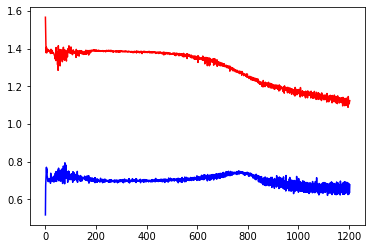

In [202]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.array(G_losses_all), 'b', label="Generator loss")
plt.plot(np.array(D_losses_all), 'r', label="Discriminator loss")